# Human Genome Language Model
1. Initialisation
    - 1.1 Imports
    - 1.2 Data processing
2. Tokenisation
    - 2.1 Fixed Length Tokenisation
    - 2.2 Variable Length Tokenisation
3. Experiments
    - 3.1 Comparing fixed and variable length tokenisation strategies

---
# 1. Initialisation
## 1.1 Imports and config
Libraries used include:
- `fastai` for access to the ULMFiT model API
- `pandas` and `matplotlib` for data science toolset

Handy tricks include:
- `autoreload` functionality so that updates to library code are automatically recompiled any time a cell is run.
- `InteractiveShell` is used for multiple outputs from a single cell.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [13]:
from fastai import *
from fastai.text import *
import sentencepiece as spm
import pandas as pd, matplotlib.pyplot as plt
import numpy as np
# import cupy as np

# Imports from GenomicULMFiT repo
sys.path.append("../../../Genomic-ULMFiT/")
sys.path.append("../..")
sys.path.append("..")

from src.processing import process_fasta
from src.config import GRCH38_P13, GENOME
from tools.config import FIGURES
from utils import tok_fixed, tok_variable, get_model_LM

In [14]:
HOME_LOCAL  = '/home/jovyan/ml_genomics'
HOME_REMOTE = '/home/athon/'

HOME        = HOME_REMOTE

THESIS      = HOME / Path('thesis/')
HUMAN       = THESIS / Path('data/human/')

In [15]:
# Dataset params
NROWS_TRAIN     = 20000
NROWS_VAL       = 20000
BATCH_SIZE      = 100

# Tokenisation - fixed
NGRAM_STRIDE    = [(3,1),(5,1),(7,1)]  #(ngram,stride) combinations for tokenisation

# Tokenisation - variable
MAX_VOCAB       = [4**3, 4**5, 4**7]

## 1.2 Data Initialisation
This process assumes data has already been read and processed into `.csv` format via the `process_fasta` script.
Data is read from `human_genome_data_fa.csv` in chunks to reduce data in memory. This can then be iterated with `df.next()`.

In [6]:
df_iter = pd.read_csv(HUMAN/'human_genome_data_fa.csv', chunksize=NROWS_TRAIN+NROWS_VAL)
df = next(df_iter)

# set val to be first 20k rows
df_tr = df[:NROWS_TRAIN]
df_va = df[NROWS_TRAIN:NROWS_TRAIN+NROWS_VAL]

In [7]:
df_tr.head()

,Sequence,Source
0,TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC...,NCBI Human
1,CATCTGCAGGTGTCTGACTTCCAGCAACTGCTGGCCTGTGCCAGGG...,NCBI Human
2,ACCTGCCCCACAGCCTTGCCTGGATTTCTATCTCCCTGGCTTGGTG...,NCBI Human
3,CTGGGGAAGCTTACTGTGTCCAAGAGCCTGCTGGGAGGGAAGTCAC...,NCBI Human
4,TGAAGATGGAGCCATATTCCTGCAGGCGCCCTGGAGCAGGGTACTT...,NCBI Human


In [8]:
df_all = pd.read_csv(HUMAN/'human_genome_data_fa.csv')

In [9]:
df_all.shape[0]*2000

2931268000

---
# 2. Tokenisation
## 2.1 Fixed length tokenisation
- Technique of original author was to iterate over entire genome sequence with for loops.
- We need to vectorise this.

,seq,vec
1,0.000569,0.000160
2,0.001204,0.000288
10,0.005928,0.001239
20,0.012116,0.002332
100,0.060991,0.011321
200,0.116085,0.022284
1000,0.596063,0.117803
2000,1.172547,0.239234
10000,6.059020,1.263272


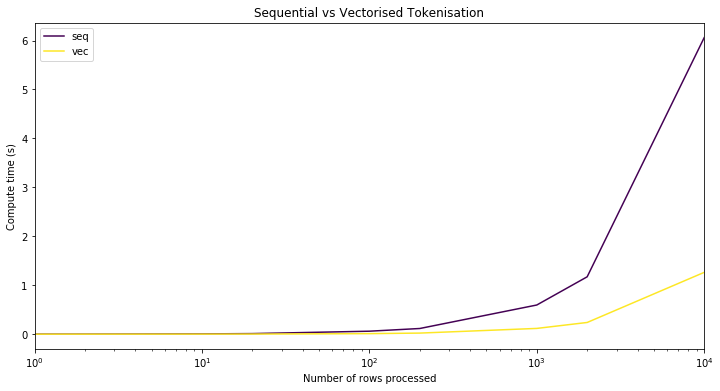

In [25]:
# from tools.tokenizers import seq_tokenizer, vec_tokenizer

def seq_tokenizer(t, ngram, stride):
    import time
    t = t.upper()
    if ngram == 1:
        toks = list(t)
    else:
        start = time.time()
        toks = [t[i:i+ngram] for i in range(0, len(t), stride) if len(t[i:i+ngram]) == ngram]

    if len(toks[-1]) < ngram:
        toks = toks[:-1]

    return toks,time.time() - start

def vec_tokenizer(a, ngram, stride):
    import numpy as np; import time
    
    def my_func(a):
        return (a[0] + a[1] + a[2])
    
    start = time.time()
    a = np.array(list(a))
    shape = ((a.size - ngram)//stride + 1, ngram)
    strides = (a.itemsize*stride, a.itemsize)
    data = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    return data, time.time() - start

# Test how well the vectorisation works
def test_tokenizers(savefig=True, title='Sequential vs Vectorised Tokenisation'):
    rows_=[]; seq_=[]; vec_=[]
    for i in [1,2,10,20,100,200,1000,2000,10000]:
        test = ''.join([''.join(row) for row in df.head(i).values[:,0]])
        toks ,time  = seq_tokenizer(test, 3, 1);seq_.append(time)
        toks_,time_ = vec_tokenizer(test, 3, 1);vec_.append(time_);rows_.append(i)
    
    fig,ax = plt.subplots(figsize=(12,6))

    stats=pd.DataFrame({'seq':seq_,'vec':vec_}, index=rows_); display(stats)
    stats.plot(ax=ax, cmap='viridis')
    ax.set_title(title)
    ax.set_ylabel('Compute time (s)')
    ax.set_xlabel('Number of rows processed'); plt.xscale('log')
    
    if savefig:
        fig.savefig(FIGURES/'tokenisation'/title.lower().replace(' ','_'), 
                    dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)
    
test_tokenizers()

### Vectorised technique for faster fixed Length tokenisation

In [11]:
import time

class FixedLengthGenomicTokenizer(BaseTokenizer):
    """
    Fixed length tokenisation for DNA.
    """
    def __init__(self, lang='en', ngram=5, stride=2):
        self.lang = lang
        self.ngram = ngram
        self.stride = stride
        
    def tokenizer(self, t):
        t = t.upper()
        if self.ngram == 1:
            toks = list(t)
        else:
            toks = [t[i:i+self.ngram] for i in range(0, len(t), self.stride) if len(t[i:i+self.ngram]) == self.ngram]
        if len(toks[-1]) < self.ngram:
            toks = toks[:-1]
        return toks
    
    def add_special_cases(self, toks):
        pass

---

# Experimental Setup
We propose to explore model performance across different fixed and variable token parameters.
For fixed length tokenisation, the parameters of interest are the number of base pairs per token, also known as `ngram`.
Additionally, the number of base pairs between the start of 1 token and the next is known as `stride`. As an example, take the sequence of base pairs:
$$\text{TCTGGCGACAACCAGGGA}$$

Using fixed length tokenisations of size **_3_** and stride **_0_**, we have the following outputs:
$$\text{[TCT],[GGC],[GAC],[AAC],[CAG],[GGA]}$$

For parameters: `{size:3, stride:1}`
$$\text{[TCT],[],[],[GGC],[],[],[GAC],[],[],[AAC],[],[],[CAG],[],[],[GGA]}$$

For parameters: `{size:5, stride:3}`
$$\text{[TCT],[GGC],[GAC],[AAC],[CAG],[GGA]}$$

For parameters: `{size:7, stride:5}`
$$\text{[TCT],[GGC],[GAC],[AAC],[CAG],[GGA]}$$


## Incorporating colour

In [15]:
from IPython.display import HTML as html_print
from pylab import *

def printc(s, color='white'):
    display(html_print("<text style=color:{}>{}</text>".format(color, s)))

def colour_gradient(n):
    cmap = cm.get_cmap('viridis', n)    # PiYG

    hexcol = []
    for i in range(cmap.N):
        rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
        c_hex = matplotlib.colors.rgb2hex(rgb)
        printc('test', str(c_hex))
        
def construct_html(wordlist, newline=50):
    html=""
    for i,pair in enumerate(wordlist):
        if (i!=0 and i%newline == 0):
            display(html_print(html))
            html=""
        html = html + "<text style=font-family:monospace;color:{1}>{0}</text>".format(*pair)
    display(html_print(html))

def hexcols(n=100):
    cmap = cm.get_cmap('viridis', n)
    return [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

# variable length tokenised data
i = 10; test = ''.join([''.join(row) for row in df.head(i).values[:,0]])
test = test[:1600]
construct_html([x for x in zip(test,hexcols(len(test)))], newline=80)

In [17]:
from utils import tok_variable
test_sp, vocab = tok_variable(df_tr, df_va, 16384)
tok_str = ''.join([str(test_sp.x[i]) for i in range(len(test_sp.x))])
tokens  = [tok for tok in tok_str.split(' ') if set(tok) <= set('ACTG')]

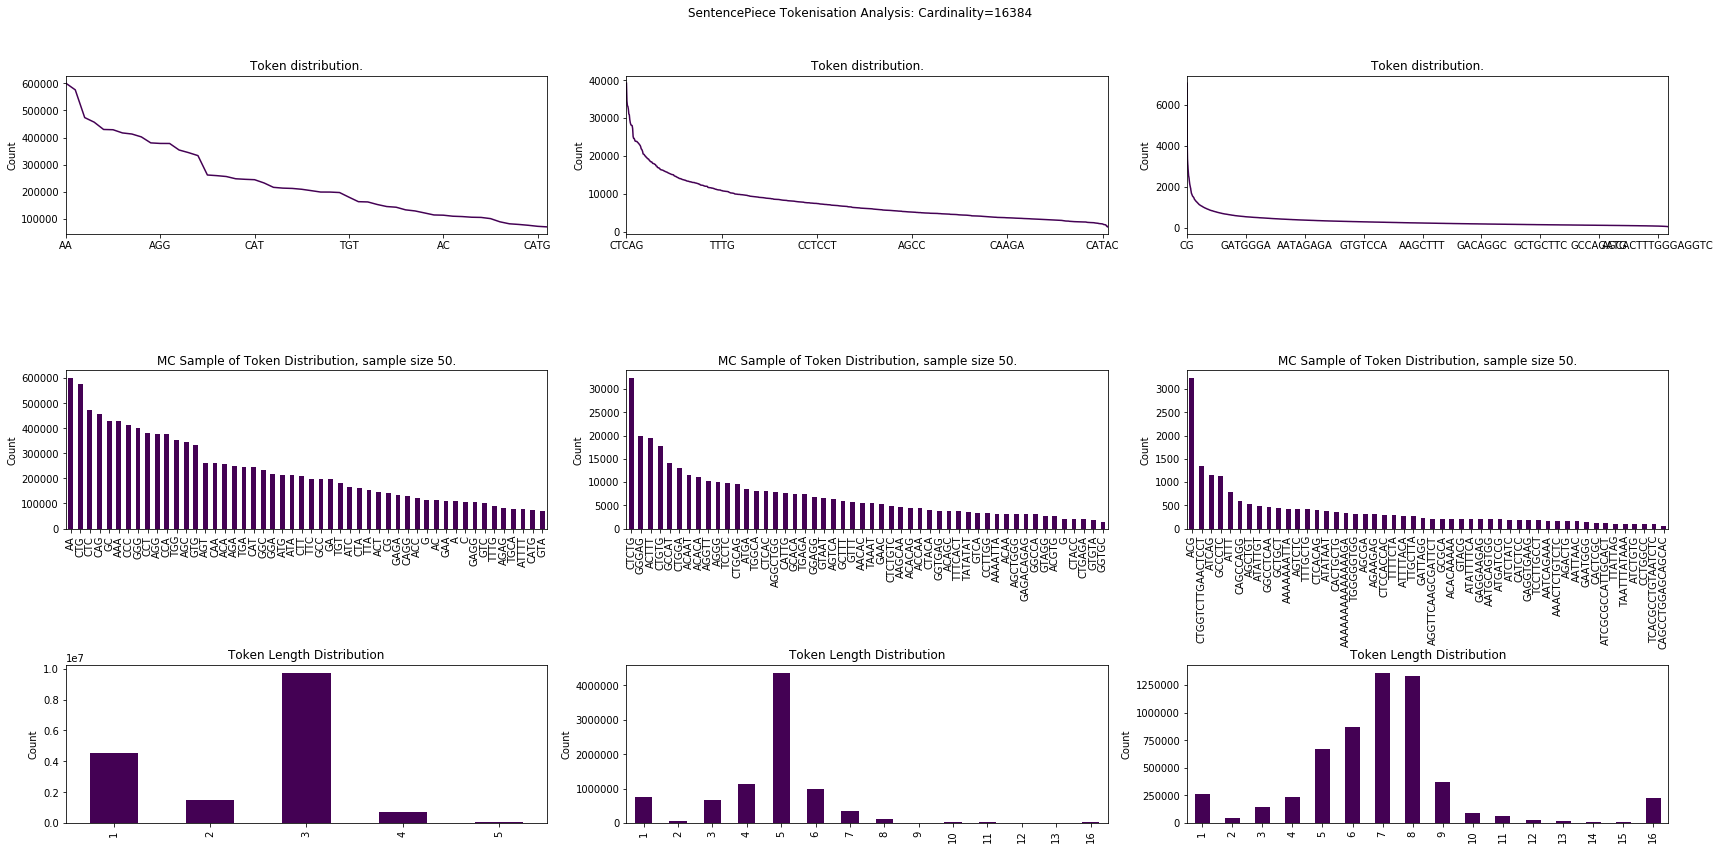

In [35]:
def plot_tok_dist(tokens, suptitle='SentencePiece Tokenisation Analysis: Cardinality=16384', sample=50, savefig=True):
    fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(24,12))
    fig.suptitle(suptitle)
    
    for i,v in enumerate(MAX_VOCAB):
        # Generate tokens
        test_sp, vocab = tok_variable(df_tr, df_va, v)
        tok_str = ''.join([str(test_sp.x[i]) for i in range(len(test_sp.x))])
        tokens  = [tok for tok in tok_str.split(' ') if set(tok) <= set('ACTG')]
        
        # Plot token statistics
        pd.Series(tokens).value_counts().tail(-1).plot(ax=axs[0,i],cmap='viridis')
        axs[0,i].set_title('Token distribution.')
        axs[0,i].set_ylabel('Count')

        pd.Series(tokens)\
            .value_counts().tail(-1).sample(sample).sort_values(ascending=False).plot.bar(ax=axs[1,i], cmap='viridis')
        axs[1,i].set_title('MC Sample of Token Distribution, sample size {}.'.format(sample))
        axs[1,i].set_ylabel('Count')

        pd.Series([len(token) for token in tokens])\
            .value_counts().sort_index().plot.bar(ax=axs[2,i], cmap='viridis')
        axs[2,i].set_title('Token Length Distribution')
        axs[2,i].set_ylabel('Count')

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
    
    if savefig:
        fig.savefig(FIGURES/'tokenisation'/suptitle.lower().replace(' ','_'), 
                    dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)
    
plot_tok_dist(tokens)

## Colouring Bases

In [51]:
# pd.Series(tokens).value_counts().tail(-1)
def vis_tokens(toks=tokens[-1000:], by='length', trim=1):
    
    if by == 'length':
        ys = [len(token) for token in toks]
    
    elif by == 'likelihood':
        counts = pd.Series(tokens).value_counts()
        ys = [counts[str(token)] if token not in counts.index[0:trim]\
              else counts.values[trim] for token in toks]
        
    ymax = max(ys); ymin = min(ys)
    print(ymax,ymin)
    cmap = cm.get_cmap('viridis', ymax)

    hexs = [matplotlib.colors.rgb2hex(cmap(y)[:3]) for y in ys]
    construct_html([x for x in zip(toks,hexs)], newline=50)

### Colour by token length

In [52]:
vis_tokens(by='length')

16 1


### Colour by token likelihood

In [53]:
vis_tokens(by='likelihood', trim=10)

3785 97


---